In [7]:
import torch as torch
import torch as t
import networkx as nx
import matplotlib.pyplot as plt
from utils_new import *
from tqdm.notebook import trange
import numpy as np
from full_model import *

## Importing Gset instance: G1

In [8]:
# default device
dd = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', dd)
t.set_default_device(dd)

Using device: cuda


In [9]:
from torch_geometric.utils import to_torch_coo_tensor
# Gset instance: G1
#importing nodes and edges
file = f'G1.txt'
print(file)
graph_name = f'G1'
g_nx = nx.read_weighted_edgelist(file)  # type: ignore
graph_info(g_nx)
g = from_networkx(G=g_nx).to(dd)

N = g.num_nodes
A_sp = to_torch_coo_tensor(edge_index=g.edge_index, size=N, edge_attr=g.weight)

# Constructing Cost matrix cut
h_sp = torch.zeros(size=(N, 1)).to_sparse_coo()
g_Jt_sp = Jt_from_Jandh(A_sp, h_sp)
g_Jt_sum = g_Jt_sp.sum().item()

# target cut value
theo = 11624

G1.txt
800 nodes, 19176 edges


## Constructing the model

In [19]:
#feature dimension d_f
feature_dim = 20
#dropout P for feature generation
f_drop = 0.0
#diffusion total time T
T = 10

In [20]:
# model
import torch.optim as optim
torch.manual_seed(0)
model = full_model(feature_dim=feature_dim, f_drop=f_drop, a_drop=0.0, device=dd, atten_bias=None).to(dd)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Training

In [21]:
LR = 1e-2
num_of_epochs = 100

In [22]:
# training
for g in optimizer.param_groups:
    g['lr'] = LR

interval = 200
tol = 1e-4
patience = 10000
highest_ratio_ = 0
Jt_sp = g_Jt_sp
print(f'Starting training with learning rate: {LR:.2E}')
count = 0
model.train()

for epoch in trange(num_of_epochs):

    # soft spin
    ss = model(Jt_sp, T=T)

    loss, loss_, hs_, hard_loss_, hard_cut_, ratio_ = evaluate_ss(
        g_Jt_sp, g_Jt_sum, ss, theo)

    if highest_ratio_ < ratio_:
        highest_ratio_ = ratio_
        best_hs_ = hs_
        print('New high:')
        print_status(epoch, loss_, ratio_)

    if epoch % interval == 0:
        print_status(epoch, loss_, ratio_)

    # early stopping check
    # If loss increases or change in loss is smaller than the tolerance, trigger

    prev_loss = loss_

    # back prop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


Starting training with learning rate: 1.00E-02


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0, Loss: 22365.49609375, Ratio: 0.00% 

New high:
Epoch: 23, Loss: 7975.267578125, Ratio: 0.25% 

New high:
Epoch: 25, Loss: 2090.7685546875, Ratio: 2.70% 

New high:
Epoch: 26, Loss: -72.90047454833984, Ratio: 71.14% 

New high:
Epoch: 27, Loss: -123.3213882446289, Ratio: 84.44% 

New high:
Epoch: 30, Loss: -203.81187438964844, Ratio: 84.94% 

New high:
Epoch: 34, Loss: -387.7630310058594, Ratio: 87.05% 

New high:
Epoch: 40, Loss: -204.1534423828125, Ratio: 87.20% 

New high:
Epoch: 42, Loss: -303.5625305175781, Ratio: 87.21% 

New high:
Epoch: 79, Loss: -397.8870849609375, Ratio: 87.25% 

New high:
Epoch: 84, Loss: -115.80674743652344, Ratio: 87.94% 

New high:
Epoch: 100, Loss: -215.97474670410156, Ratio: 88.08% 



In [23]:
ss = model(Jt_sp, T)
final_state = hard_project(ss)
_, loss_, hs_, hard_loss_, hard_cut_, ratio_ = evaluate_ss(
    g_Jt_sp, g_Jt_sum, ss, theo)

print('')

print('Final Evaluation:')
print_status(num_of_epochs, loss_, ratio_)


Final Evaluation:
Epoch: 200, Loss: -168.15744018554688, Ratio: 82.83% 



## Post-training Visualisation

In [24]:
model.eval()

N_1 = Jt_sp.shape[0]

adj_ind, Jt_val = iv_from_sp(Jt_sp)
Jt_val_abs_norm = sym_norm_abs(adj_ind, Jt_val, N_1)

# feature generated
f = model.m_fgen(Jt_sp)

# softmax normalised a_ij
a_val = model.m_atten(adj_ind,Jt_val, f, N_1)

# polarised attention, polarisation = opposite of Jt
pol_a_val = -t.sign(Jt_val) * a_val

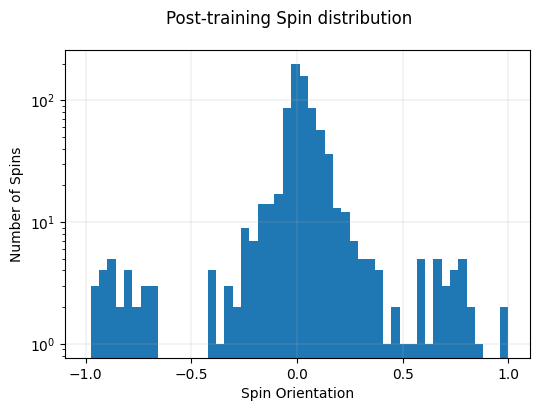

In [25]:
model.eval()

N_1 = Jt_sp.shape[0]

adj_ind, Jt_val = iv_from_sp(Jt_sp)
Jt_val_abs_norm = sym_norm_abs(adj_ind, Jt_val, N_1)

# feature generated
f = model.m_fgen(Jt_sp)

# softmax normalised a_ij
a_val = model.m_atten(adj_ind,Jt_val, f, N_1)

fig, ax = plt.subplots(figsize=(6, 4))
plt.yscale('log')

ax.set(ylabel='Number of Spins',
       xlim=(-1.1,1.1), xticks=np.array([-1,-0.5,0,0.5,1]), xlabel='Spin Orientation')
ax.set_yticks([1,10,100,1000],minor=False)
ax.grid(True, linewidth=0.2)

fig.suptitle('Post-training Spin distribution')
_, _, _ = plt.hist(ss.squeeze(1).detach().cpu().numpy(), bins=50)

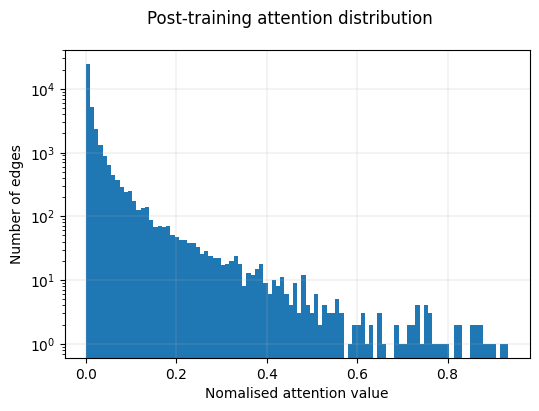

In [26]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.yscale('log')

# ax.set(ylabel='Number of edges',
#        xlim=(-0.1,1.1), xticks=np.array([0,0.25,0.5,0.75,1]), xlabel='Nomalised attention value')
ax.set(ylabel='Number of edges',
       xlabel='Nomalised attention value')

# ax.set_yticks([1,10,100,1000],minor=False)
ax.grid(True, linewidth=0.2)

fig.suptitle('Post-training attention distribution')
n, bins, _ = plt.hist(a_val.detach().cpu().numpy(), bins=100)

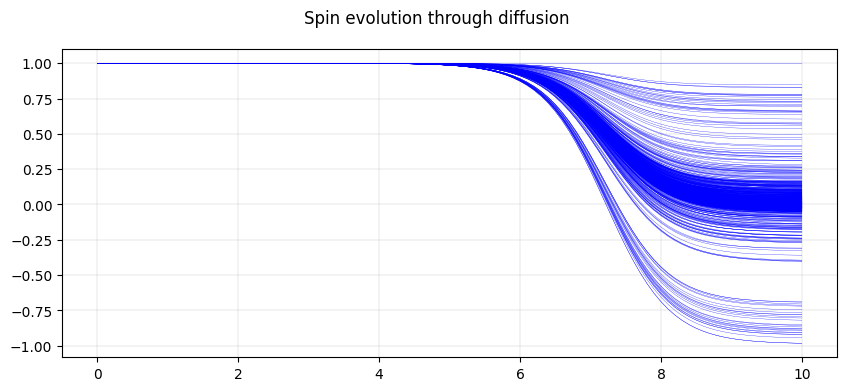

In [27]:
dt=0.1

# diffusion operator = I + dt* del_t_operator = (1-dt)*I + dt*(Pol_atten)
diff_ind, diff_val = add_self_loops(
    edge_index=adj_ind, edge_attr=(dt * pol_a_val), fill_value=(1 - dt)
)

# indices
diff_i, diff_j = diff_ind

# clear the first row
diff_val[diff_i == 0] = 0  # type: ignore

# make (0,0) in the first row a 1 to keep the external spin
diff_val[(diff_i == 0) * (diff_j == 0)] = 1  # type: ignore

# diffusion linear operator
diff_sp = sp_from_iv(diff_ind, diff_val, N=N_1)

total_steps = int(T / dt)

spins = t.ones((N_1, 1)).to(dd)

spins_evolution = spins.clone()


for _ in range(total_steps):
    spins = t.sparse.mm(diff_sp, spins)
    spins_evolution = t.cat([spins_evolution, spins], dim=1)

evol = spins_evolution[1:]
amax, _ = evol.abs().max(dim=0)
evol = evol/amax
evol = evol.detach().cpu().numpy()
n = evol.shape[0]
steps = evol.shape[1]

x = np.arange(steps)*dt

plt.close('all')
fig, ax = plt.subplots(figsize=(10,4))

# ax.set(ylim=(-1.1, 1.1), ylabel='Spin direction',
#        xlim=(0,T), xlabel='Time')
ax.grid(True, linewidth=0.2)

fig.suptitle('Spin evolution through diffusion')

from_time = 0
from_frame = int(from_time/dt)
# n=10
for i in range(n):
    plt.plot(x[from_frame:], evol[i,from_frame:],'-b', linewidth=0.2)

# fig.savefig(f'figures/{graph_name}_Diffusion_.png', dpi=400)